In [1]:
import sys
sys.path.append('/home/js2164/jan/repos/diffusion/score_sde_pytorch')
import os
os.chdir('/home/js2164/jan/repos/diffusion/score_sde_pytorch')

import torch
import numpy as np
import pickle
from matplotlib import pyplot as plt

In [2]:
#path = 'logs/ksphere/2d_toy_2/svd/svd_23500.pkl'
#path = 'logs/ksphere/dim_10/n_1/random_isometry/non_uniform_0.5_sig_0.001/svd/svd_23000.pkl'
#path = 'logs/ksphere/n_2/dim_[1, 2]/random_isometry/different_dims_different_radii_toy/svd/svd_4000.pkl'
path = 'logs/ksphere/n_2/dim_[10, 30]/random_isometry/different_dims_different_radii/svd/svd_15500.pkl'
with open(path, 'rb') as f:
    svd = pickle.load(f)

singular_values = svd['singular_values']

In [3]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()
#from scipy.special import softmax as 

dims = []
for sing_vals in singular_values:
    difference = np.array([sing_vals[i-1] / sing_vals[i] for i in range(1, len(sing_vals))])
    probs = softmax(difference)
    d = len(probs) - np.argmax(probs)
    dims.append(d)

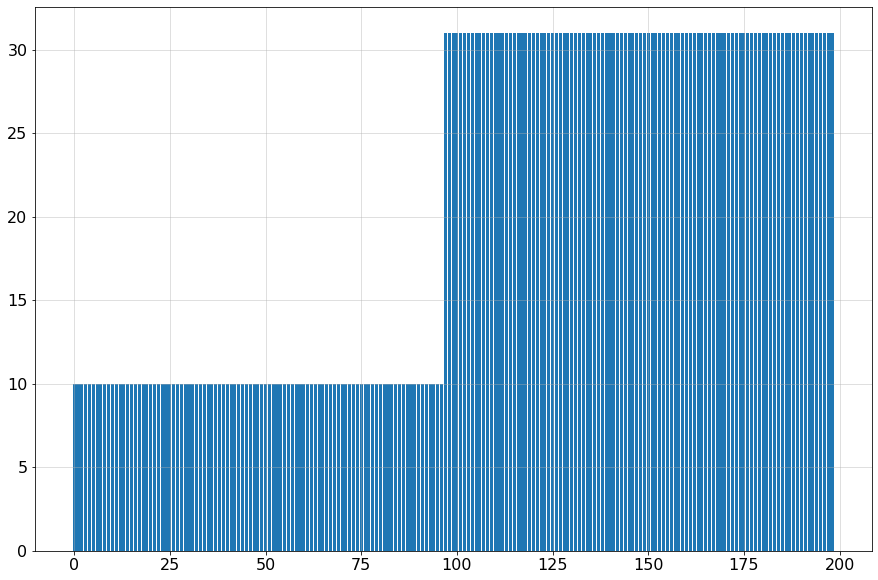

In [5]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 16})
#if alpha > 0:
#    plt.title(f'Non-uniform distribution $\\alpha={alpha}$')
#else:
#    plt.title(f'Uniform distribution')
plt.grid(alpha=0.5)
plt.bar(range(len(dims)), np.sort(dims))
#plt.xlabel('i-th point')
#plt.ylabel('Estimated dimension at i-th point')
#alpha_str =str(alpha).replace('.', '_')
plt.savefig(f'figures/union_dims', dpi=300, facecolor='white')
plt.show()

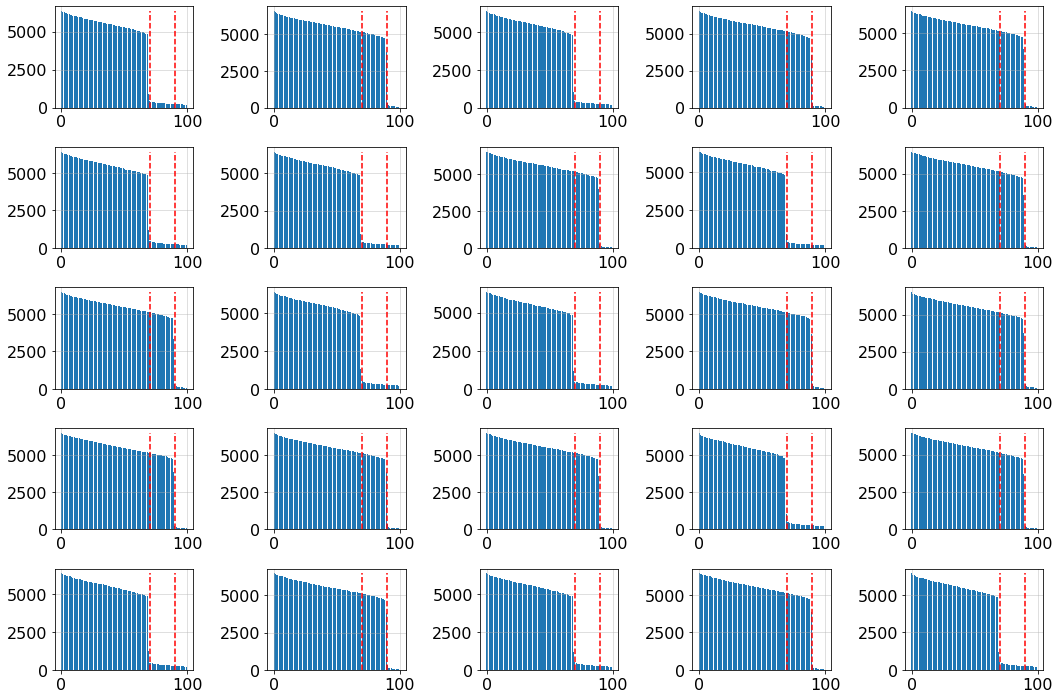

In [6]:
fig = plt.figure(figsize=(15,10))
for i, s in enumerate(singular_values[:25]):
    ax = fig.add_subplot(5, 5, i+1)
    #ax.rcParams.update({'font.size': 16})
    ax.grid(alpha=0.5)
    ax.bar(range(len(s)), s)
    #ax.xticks(range(0, 100, 5))
    ax.vlines(90, 0, np.max(s), color='r', linestyles='--')
    ax.vlines(70, 0, np.max(s), color='r', linestyles='--')
fig.tight_layout()
fig.savefig(f'figures/union_spectrum', dpi=300, facecolor='white')
fig.show()

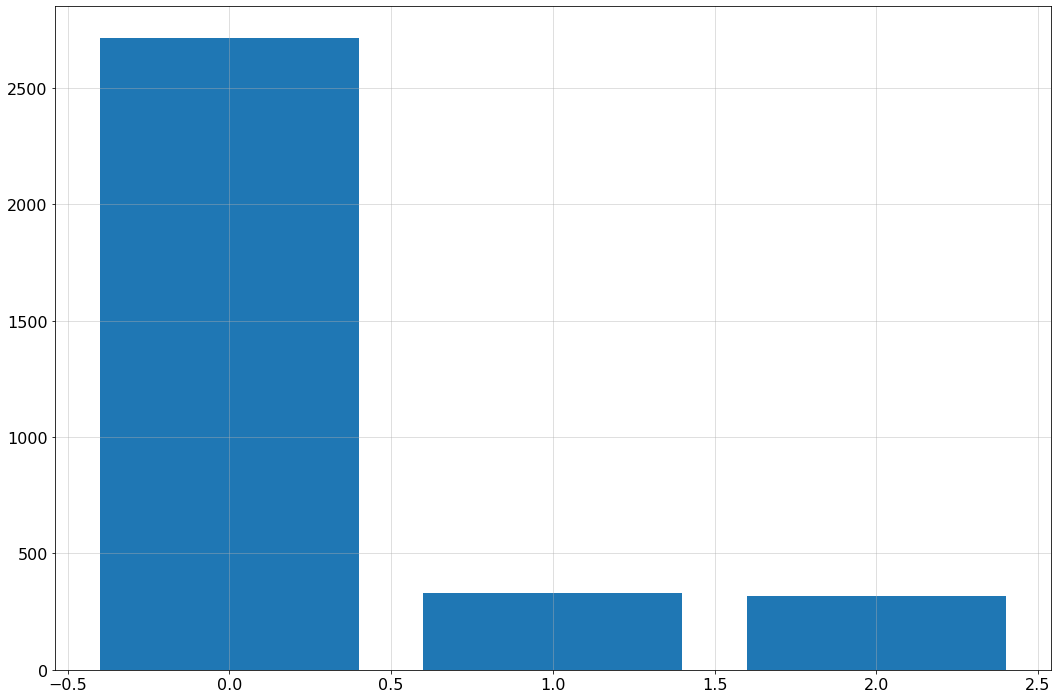

In [8]:
s = singular_values[100]
fig = plt.figure(figsize=(15,10))
#ax.rcParams.update({'font.size': 16})
plt.grid(alpha=0.5)
plt.bar(range(len(s)), s)
#plt.xticks(range(0, 100, 5))
#plt.vlines(95, 0, np.max(s), color='r', linestyles='--')
#plt.vlines(70, 0, np.max(s), color='r', linestyles='--')
fig.tight_layout()
fig.show()

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from lightning_modules.BaseSdeGenerativeModel import BaseSdeGenerativeModel
from models.fcn import FCN
from models.fcn_potential import FCN_Potential
import pickle
import sde_lib
import os

In [9]:
config_path = 'logs/ksphere/n_2/dim_[1, 2]/random_isometry/different_dims_different_radii_toy/config.pkl'
with open(config_path, 'rb') as file:
    config = pickle.load(file)

ckpt_path = 'logs/ksphere/n_2/dim_[1, 2]/random_isometry/different_dims_different_radii_toy/checkpoints/best/epoch=18062--eval_loss_epoch=6.477.ckpt'
pl_module = BaseSdeGenerativeModel.load_from_checkpoint(ckpt_path)
score_model = pl_module.score_model
pl_module.configure_sde(config)
pl_module = pl_module.eval()

In [49]:
X, Y, Z = np.meshgrid(np.arange(-1, 1, 0.2),
                      np.arange(-1, 1, 0.2),
                      np.arange(-1, 1, 0.2))

In [12]:
from models.utils import get_score_fn
device = pl_module.device
score_fn = get_score_fn(pl_module.sde, pl_module.score_model, train=False, continuous=True)
#n = len(X[0])

t=0.0
#XYpairs = np.stack([ X.reshape(-1), Y.reshape(-1), Z.reshape(-1) ], axis=1)
#xs = torch.tensor(XYpairs, dtype=torch.float, requires_grad=True, device=device)
xs = data
ts = torch.tensor([t] * xs.shape[0], dtype=torch.float, device=device)
#out = score_fn(xs, ts).view(list(X.shape) + [3])

#out_X = out[:,:,:,0].cpu().detach().numpy()
#out_Y = out[:,:,:,1].cpu().detach().numpy()
#out_Z = out[:,:,:,2].cpu().detach().numpy()

out = score_fn(xs, ts)
out_X = out[:,0].cpu().detach().numpy()
out_Y = out[:,1].cpu().detach().numpy()
out_Z = out[:,2].cpu().detach().numpy()

In [13]:
X = data[:,0]
Y = data[:,1]
Z = data[:,2]

In [10]:
def sample_sphere(n_samples, manifold_dim, std=-1):

    def polar_to_cartesian(angles):
        xs = []
        sin_prod=1
        for i in range(len(angles)):
            x_i = sin_prod * torch.cos(angles[i])
            xs.append(x_i)
            sin_prod *= torch.sin(angles[i])
        xs.append(sin_prod)
        return torch.stack(xs)[None, ...]

    if std == -1:
        new_data = torch.randn((n_samples, manifold_dim+1))
        norms = torch.linalg.norm(new_data, dim=1)
        new_data = new_data / norms[:,None]
        return new_data
    else:
        sampled_angles = std * torch.randn((n_samples,manifold_dim))
        return torch.cat([polar_to_cartesian(angles) for angles in sampled_angles], dim=0)  
        
def generate_data(n_samples, n_spheres, ambient_dim, 
                        manifold_dim, noise_std, embedding_type,
                        radii, angle_std):
            if radii == []:
                radii = [1] * n_spheres

            if isinstance(manifold_dim, int):
                manifold_dims = [manifold_dim] * n_spheres
            elif isinstance(manifold_dim, list):
                manifold_dims = manifold_dim
                
            data = []
            for i in range(n_spheres):
                    manifold_dim = manifold_dims[i]
                    new_data = sample_sphere(n_samples, manifold_dim, angle_std)
                    new_data = new_data * radii[i]

                    if embedding_type == 'random_isometry':
                        # random isometric embedding
                        randomness_generator = torch.Generator().manual_seed(0)
                        embedding_matrix = torch.randn(size=(ambient_dim, manifold_dim+1), generator=randomness_generator)
                        q, r = np.linalg.qr(embedding_matrix)
                        q = torch.from_numpy(q)
                        new_data = (q @ new_data.T).T
                    elif embedding_type == 'first':
                        # embedding into first manifold_dim + 1 dimensions
                        suffix_zeros = torch.zeros([n_samples, ambient_dim - new_data.shape[1]])
                        new_data = torch.cat([new_data, suffix_zeros], dim=1)
                    elif embedding_type == 'separating':
                        # embbedding which puts spheres in non-intersecting dimensions
                        if n_spheres * (manifold_dim + 1) > ambient_dim:
                            raise RuntimeError('Cant fit that many spheres. Enusre that n_spheres * (manifold_dim + 1) <= ambient_dim')
                        prefix_zeros = torch.zeros((n_samples, i * (manifold_dim + 1)))
                        new_data = torch.cat([prefix_zeros, new_data], dim=1)
                        suffix_zeros = torch.zeros([n_samples, ambient_dim - new_data.shape[1]])
                        new_data = torch.cat([new_data, suffix_zeros], dim=1)
                    elif embedding_type == 'along_axis':
                        # embbedding which puts spheres in non-intersecting dimensions
                        if (n_spheres - 1) + (manifold_dim + 1) > ambient_dim:
                            raise RuntimeError('Cant fit that many spheres.')
                        prefix_zeros = torch.zeros((n_samples, i))
                        new_data = torch.cat([prefix_zeros, new_data], dim=1)
                        suffix_zeros = torch.zeros([n_samples, ambient_dim - new_data.shape[1]])
                        new_data = torch.cat([new_data, suffix_zeros], dim=1)    
                    else:
                        raise RuntimeError('Unknown embedding type.')
                        
                    # add noise
                    new_data = new_data + noise_std * torch.randn_like(new_data)
                    data.append(new_data)

            data = torch.cat(data, dim=0)
            return data
            
data = generate_data(int(5e4), 2, 3, [1, 2], 0.01, 'random_isometry', [1, 0.25], -1)

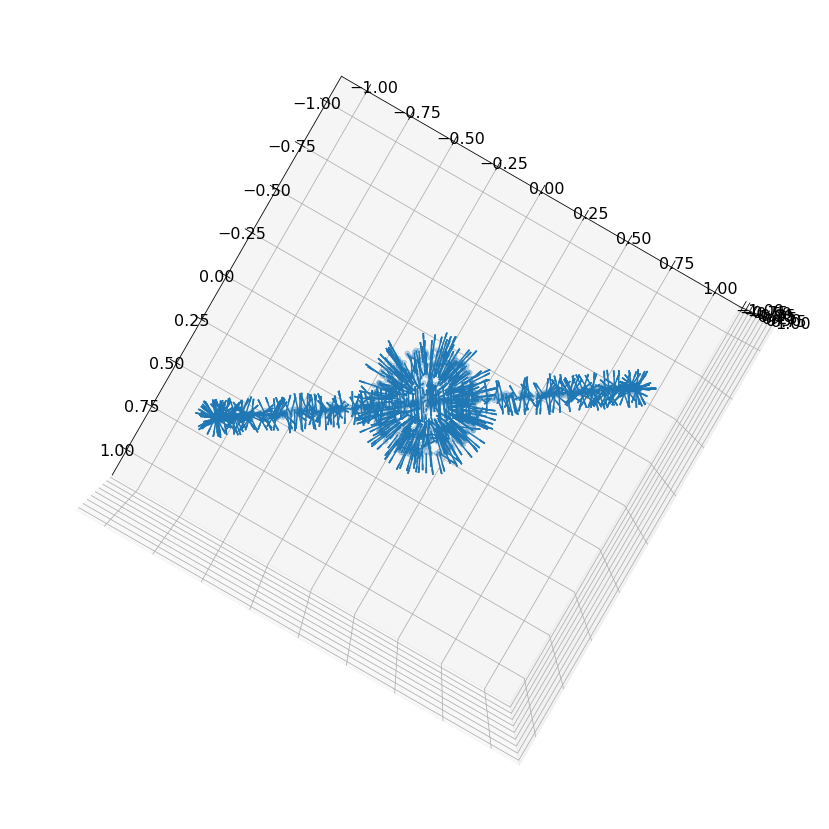

In [17]:
fig = plt.figure(figsize=(15,15))
plotting_n = 1000
ids = np.random.randint(0, data.shape[0], plotting_n)
plt_data = data.numpy()[ids]
ax = fig.add_subplot(projection='3d')
ax.view_init(93,30)
ax.scatter(plt_data[:,0], plt_data[:,1], plt_data[:,2], alpha=0.25)
minbound=-1
maxbound=1
ax.auto_scale_xyz([minbound, maxbound], [minbound, maxbound], [minbound, maxbound])
ax.set_box_aspect(aspect = (1,1,1))

ax.quiver(X[ids], Y[ids], Z[ids], out_X[ids], out_Y[ids], out_Z[ids], length=0.1, normalize=True)
plt.show()

: 